# Study of Opening Hours of Restaurants

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import folium
import seaborn

In [2]:
seaborn.set()

In [3]:
# Load the data from the file
data_path = "./opening_hours.json"
data = pd.read_json(data_path, lines = True)

## Overview

### Distribution of Hours of Operation Each Day in A Week

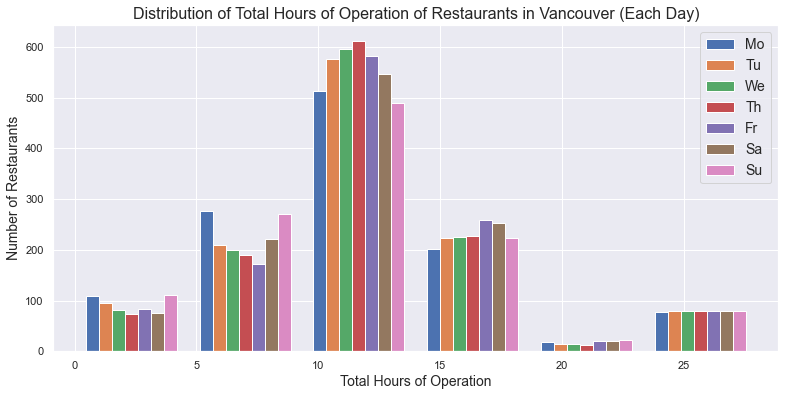

In [4]:
day_of_week = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]
opening_hours = pd.DataFrame(data['opening_hours'].to_dict()).transpose()
opening_hours
plt.figure(figsize = (13, 6))
plt.hist(
    [opening_hours[key] for key in day_of_week], 
    np.linspace(0, 28, 7)
)
plt.title("Distribution of Total Hours of Operation of Restaurants in Vancouver (Each Day)", fontsize = 16)
plt.xlabel("Total Hours of Operation", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.legend(day_of_week, fontsize = 14)
plt.show()

### Distribution of Total Hours of Operation in A Week

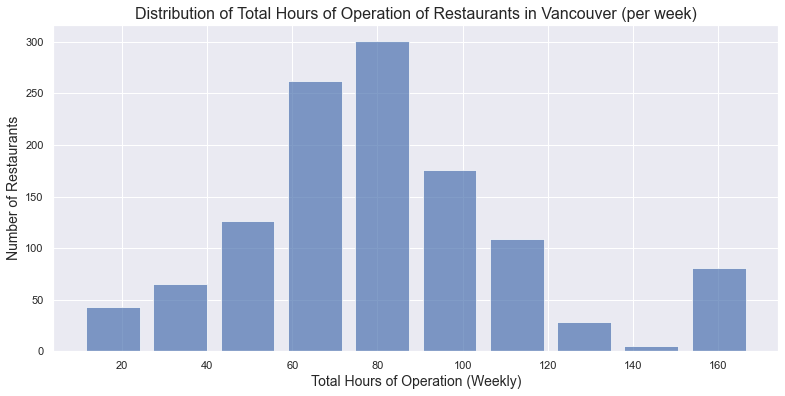

In [5]:
plt.figure(figsize = (13, 6))
plt.hist(
    data['opening_hours_per_week'], 
    rwidth = 0.8, 
    alpha = 0.7
)
plt.title("Distribution of Total Hours of Operation of Restaurants in Vancouver (per week)", fontsize = 16)
plt.xlabel("Total Hours of Operation (Weekly)", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.show()

## Chain Restaurants vs. Non-chain Restaurants

In [6]:
chain = data[data.apply(lambda x: 'brand' in x['tags'], axis = 1)].reset_index(drop = True)
non_chain = data[data.apply(lambda x: 'brand' not in x['tags'], axis = 1)].reset_index(drop = True)

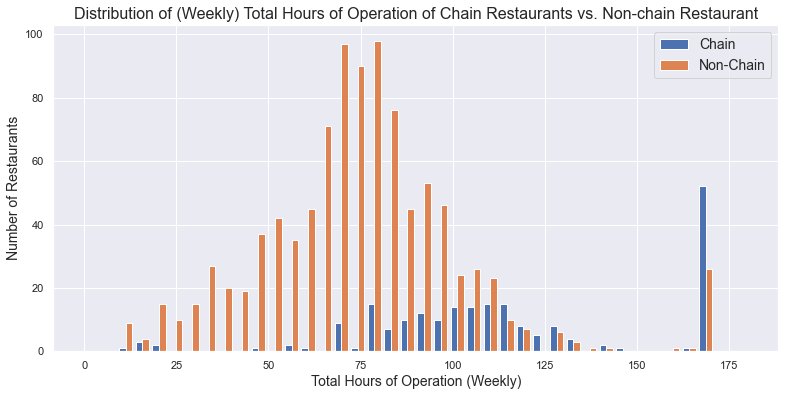

In [7]:
plt.figure(figsize = (13, 6))
plt.hist([
    chain['opening_hours_per_week'], 
    non_chain['opening_hours_per_week']], 
    np.linspace(0, 180, 41)
)
plt.title("Distribution of (Weekly) Total Hours of Operation of Chain Restaurants vs. Non-chain Restaurant", fontsize = 16)
plt.xlabel("Total Hours of Operation (Weekly)", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.legend(["Chain", "Non-Chain"], fontsize = 14)
plt.show()

### Statistical Tests

#### Do chain restaurants have a longer opening hours?

In [8]:
data_x, data_y = chain['opening_hours_per_week'], non_chain['opening_hours_per_week']

In [9]:
# Are they normally distributed
print(stats.normaltest(data_x).pvalue)
print(stats.normaltest(data_y).pvalue)

0.7362092816992584
9.557252554652752e-29


In [10]:
# Do they have equal variance?
print(stats.levene(data_x, data_y).pvalue)

1.2136306280197282e-09


In [11]:
# Perform a T-test
print(stats.ttest_ind(data_x, data_y, equal_var = False).pvalue)

9.725496243215882e-37


## Weekday vs. Weekend